## Exploratory Data Analysis

Use this notebook to get familiar with the datasets we have. There is 10 questions we need to answer during the EDA (Exploratory Data Analysis).


We shouldn't limit our EDA to these 10 questions. Let's be creative :).

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import warnings
import seaborn as sns
import requests
from src.config import WEATHER_API_KEY

In [40]:
warnings.filterwarnings('ignore')

In [41]:
fn_flight = '../data/flight_data.csv'
fn_passenger = '../data/passengers_sample.csv'
fn_fuel = '../data/fuel_consumption.csv'

In [42]:
flight_df = pd.read_csv(fn_flight)
passenger_df = pd.read_csv(fn_passenger)
fuel_df = pd.read_csv(fn_fuel)

In [43]:
flight_df.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name,row
0,2018-01-01,UA,UA_CODESHARE,UA,3542,YX,N637RW,3542,13495,MSY,...,0.0,0.0,0.0,0.0,122.0,NaN,NaN,NaN,NaN,150
1,2018-01-01,UA,UA_CODESHARE,UA,3725,YX,N861RW,3725,14869,SLC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300
2,2018-01-01,AA,AA,AA,1675,AA,N604AW,1675,11298,DFW,...,16.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,450
3,2018-01-01,AA,AA,AA,1035,AA,N314PD,1035,14679,SAN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,600
4,2018-01-01,AA,AA,AA,1412,AA,N936NN,1412,13891,ONT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,750


In [44]:
flight_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106183 entries, 0 to 106182
Data columns (total 43 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   fl_date              106183 non-null  object 
 1   mkt_unique_carrier   106183 non-null  object 
 2   branded_code_share   106183 non-null  object 
 3   mkt_carrier          106183 non-null  object 
 4   mkt_carrier_fl_num   106183 non-null  int64  
 5   op_unique_carrier    106183 non-null  object 
 6   tail_num             105844 non-null  object 
 7   op_carrier_fl_num    106183 non-null  int64  
 8   origin_airport_id    106183 non-null  int64  
 9   origin               106183 non-null  object 
 10  origin_city_name     106183 non-null  object 
 11  dest_airport_id      106183 non-null  int64  
 12  dest                 106183 non-null  object 
 13  dest_city_name       106183 non-null  object 
 14  crs_dep_time         106183 non-null  int64  
 15  dep_time         

In [45]:
# flight_df[flight_df.columns[flight_df.columns != 'object']]
num = flight_df.columns[flight_df.dtypes != 'object'].tolist()
flight_df['dep_delay'].describe()

count    104488.000000
mean         10.839532
std          49.058229
min        -147.000000
25%          -6.000000
50%          -2.000000
75%           7.000000
max        1788.000000
Name: dep_delay, dtype: float64

#### **Task 1**: Test the hypothesis that the delay is from Normal distribution. and that **mean** of the delay is 0. Be careful about the outliers.

In [93]:
stats.shapiro(flight_df['dep_delay'].dropna())

ShapiroResult(statistic=0.3714328408241272, pvalue=0.0)

In [96]:
delays = flight_df['dep_delay'][flight_df['dep_delay'] > 0]
stats.shapiro(delays)

ShapiroResult(statistic=0.4934779405593872, pvalue=0.0)

In [97]:
stats.shapiro(np.log(delays))

ShapiroResult(statistic=0.9852893352508545, pvalue=0.0)

<AxesSubplot:xlabel='dep_delay', ylabel='Density'>

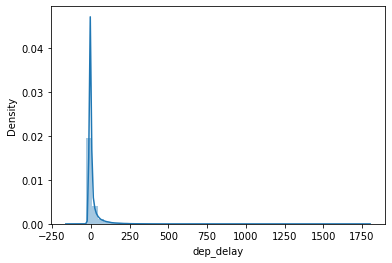

In [98]:
sns.distplot(flight_df['dep_delay'].dropna())

<AxesSubplot:xlabel='dep_delay', ylabel='Density'>

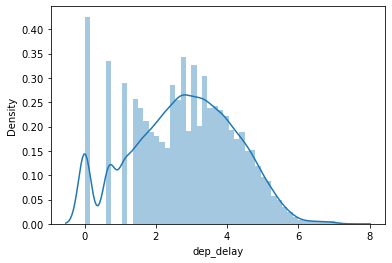

In [99]:
sns.distplot(np.log(delays))

#### **Task 2**: Is average/median monthly delay different during the year? If yes, which are months with the biggest delays and what could be the reason?

In [110]:
flight_df['month'] = flight_df['fl_date'].str[5:-3]
flight_df[['month', 'dep_delay']].groupby(['month']).mean().sort_values('dep_delay')

,dep_delay
month,
10,6.859221
09,7.526791
03,8.714156
11,8.808516
04,8.903935
01,10.950055
12,11.634633
02,12.027834
05,12.089112


#### **Task 3**: Does the weather affect the delay? 
Use the API to pull the weather information for flights. There is no need to get weather for ALL flights. We can choose the right representative sample. Let's focus on four weather types:
- sunny
- cloudy
- rainy
- snow.
Test the hypothesis that these 4 delays are from the same distribution. If they are not, which ones are significantly different?

In [151]:
def get_request(url, headers=None, params=None):
    headers = headers if headers else {}
    params = params if params else {}
    return requests.get(url=url, params=params, headers=headers)

In [152]:
headers = {

}
params = {
    'q': 'Phoenix,AZ',  # location e.g. q=New+york,ny
    'date': '2018-01-02',  # date format yyyy-MM-dd
    'format': 'json',
    'key': WEATHER_API_KEY

}
url = 'https://api.worldweatheronline.com/premium/v1/past-weather.ashx'

In [153]:
res = get_request(url, headers, params)

In [156]:
def get_weather(url, headers, params):
    pois = ['windspeedKmph', 'visibility', 'cloudcover', 'precipMM', 'totalSnow_cm']
    request = get_request(url, headers, params)
    if not request:
        return 'Unsuccessful request'
    data = request.json().get('data', {}).get('weather', [dict()])[0].get('hourly', [])
    return [{k:weather.get(k, None) for k in pois} for weather in data]

In [157]:
# look into sunny, cloudy, rainy, snow, visibility, (weatherCode????)
get_weather(url, headers, params)
# TODO: ADD TIME 

[{'windspeedKmph': '2',
  'visibility': '10',
  'cloudcover': '12',
  'precipMM': '0.0',
  'totalSnow_cm': None},
 {'windspeedKmph': '2',
  'visibility': '10',
  'cloudcover': '32',
  'precipMM': '0.0',
  'totalSnow_cm': None},
 {'windspeedKmph': '10',
  'visibility': '10',
  'cloudcover': '100',
  'precipMM': '0.0',
  'totalSnow_cm': None},
 {'windspeedKmph': '5',
  'visibility': '10',
  'cloudcover': '99',
  'precipMM': '0.0',
  'totalSnow_cm': None},
 {'windspeedKmph': '7',
  'visibility': '10',
  'cloudcover': '87',
  'precipMM': '0.0',
  'totalSnow_cm': None},
 {'windspeedKmph': '4',
  'visibility': '10',
  'cloudcover': '22',
  'precipMM': '0.0',
  'totalSnow_cm': None},
 {'windspeedKmph': '3',
  'visibility': '10',
  'cloudcover': '20',
  'precipMM': '0.0',
  'totalSnow_cm': None},
 {'windspeedKmph': '8',
  'visibility': '10',
  'cloudcover': '12',
  'precipMM': '0.0',
  'totalSnow_cm': None}]

#### **Task 4**: How taxi times changing during the day? Does higher traffic lead to bigger taxi times?

#### **Task 5**: What is the average percentage of delays that is already created before departure? (aka are arrival delays caused by departure delays?) Are airlines able to lower the delay during the flights?

#### **Task 6**: How many states cover 50% of US air traffic? 

#### **Task 7**: Test the hypothesis whether planes fly faster when there is the departure delay? 

#### **Task 8**: When (which hour) do most 'LONG', 'SHORT', 'MEDIUM' haul flights take off?

#### **Task 9**: Find the top 10 the bussiest airports. Does the biggest number of flights mean that the biggest number of passengers went through the particular airport? How much traffic do these 10 airports cover?

#### **Task 10**: Do bigger delays lead to bigger fuel comsumption per passenger? 
We need to do four things to answer this as accurate as possible:
- Find out average monthly delay per air carrier (monthly delay is sum of all delays in 1 month)
- Find out distance covered monthly by different air carriers
- Find out number of passengers that were carried by different air carriers
- Find out total fuel comsumption per air carrier.

Use this information to get the average fuel comsumption per passenger per km. Is this higher for the airlines with bigger average delays?